# Dylan Yaghoutiel -- Final Project -- Modeling Notebook:

Link to page with general description of the data: https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition


Read the article (https://doi.org/10.1016/j.dib.2019.104344) to see the description of the attributes.

# Importing Libraries and Creating the DataFrame

In [74]:
#import anything you may need over the course of this project
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

from sklearn.compose import make_column_transformer
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

import torch
import torch.nn as nn
import torch.optim as optim

from google.colab import files

In [2]:
#add ObesityDataset file to files in Colab and create DataFrame

obesity = pd.read_csv('/content/ObesityDataSet_raw_and_data_sinthetic.csv')

'''
Some important things to note:

'Height' is measured in meters
'Weight' is measured in kilograms
'Age' is measured in years
'FCVC': 1 = Never eats vegetables in meals, 2 = sometimes eats vegetables in meals, 3 = always eats vegetables in meals
'NCP': 1 = eats 1-2 meals daily, 2 = eats 3 meals daily, 3 = eats more than 3 meals daily
'CH2O': 1 = drinks less than 1L of water per day, 2 = drinks 1-2L of water per day, 3 = drinks more than 2L of water per day
'FAF': 0 = no physical activity per week, 1 = 1-2 days physical activity per week, 2 = 2-4 days physical activity per week, 3  4-5 days physical activity per week
'TUE': 0 = 0-2 hours of tech usage per day, 1 = 3-5 hours of tech usage per day, 2 = more than 5 hours tech usage per day
'''

obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
obesity.info()

'''
There are no missing values in the dataset.
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

'\nThere are no missing values in the dataset.\n'

In [4]:
obesity.describe(include = 'all')

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
count,2111,2111.000000,2111.000000,2111.000000,2111,2111,2111.000000,2111.000000,2111,2111,2111.000000,2111,2111.000000,2111.000000,2111,2111,2111
unique,2,NaN,NaN,NaN,2,2,NaN,NaN,4,2,NaN,2,NaN,NaN,4,5,7
top,Male,NaN,NaN,NaN,yes,yes,NaN,NaN,Sometimes,no,NaN,no,NaN,NaN,Sometimes,Public_Transportation,Obesity_Type_I
freq,1068,NaN,NaN,NaN,1726,1866,NaN,NaN,1765,2067,NaN,2015,NaN,NaN,1401,1580,351
mean,NaN,24.312600,1.701677,86.586058,NaN,NaN,2.419043,2.685628,NaN,NaN,2.008011,NaN,1.010298,0.657866,NaN,NaN,NaN
std,NaN,6.345968,0.093305,26.191172,NaN,NaN,0.533927,0.778039,NaN,NaN,0.612953,NaN,0.850592,0.608927,NaN,NaN,NaN
min,NaN,14.000000,1.450000,39.000000,NaN,NaN,1.000000,1.000000,NaN,NaN,1.000000,NaN,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,19.947192,1.630000,65.473343,NaN,NaN,2.000000,2.658738,NaN,NaN,1.584812,NaN,0.124505,0.000000,NaN,NaN,NaN
50%,NaN,22.777890,1.700499,83.000000,NaN,NaN,2.385502,3.000000,NaN,NaN,2.000000,NaN,1.000000,0.625350,NaN,NaN,NaN
75%,NaN,26.000000,1.768464,107.430682,NaN,NaN,3.000000,3.000000,NaN,NaN,2.477420,NaN,1.666678,1.000000,NaN,NaN,NaN


# DataFrame Adjustments

In [5]:
#make adjustments to the DataFrame:
#add a 'Height (ft)' column and remove the 'Height' column
obesity['Height (ft)'] = (obesity['Height'] * 3.281).round(2)
obesity.drop(columns = 'Height', inplace = True)

#add a 'Weight (lbs)' column and remove the 'Weight' column
obesity['Weight (lbs)'] = (obesity['Weight'] * 2.205).round(2)
obesity.drop(columns = 'Weight', inplace = True)

#rename the 'Age' column to 'Age (yrs)'
obesity.rename(columns = {'Age': 'Age (yrs)'}, inplace = True)

#move the new columns to where the previously-removed columns were
obesity = obesity[['Gender', 'Age (yrs)', 'Height (ft)', 'Weight (lbs)', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad']]

obesity.head()

,Gender,Age (yrs),Height (ft),Weight (lbs),family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,5.32,141.12,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,4.99,123.48,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,5.91,169.78,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,5.91,191.84,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,5.84,198.01,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [6]:
#further adjustments to make DataFrame more readable:
#change various column names so we don't have to constantly have to refer to the data's description page for info:
#change 'family_history_with_overweight' to 'Family_History_Overweight'
obesity.rename(columns = {'family_history_with_overweight': 'Family_History_Overweight'}, inplace = True)

#change 'FAVC' to 'High_Caloric_Diet'
obesity.rename(columns = {'FAVC': 'High_Caloric_Diet'}, inplace = True)

#change 'FCVC' to 'Vegetable_Consumption'
obesity.rename(columns = {'FCVC': 'Vegetable_Consumption'}, inplace = True)

#change 'NCP' to 'Number_Daily_Meals'
obesity.rename(columns = {'NCP': 'Number_Daily_Meals'}, inplace = True)

#change 'CAEC' to 'Food_Between_Meals'
obesity.rename(columns = {'CAEC': 'Food_Between_Meals'}, inplace = True)

#change 'SMOKE' to 'Smokes'
obesity.rename(columns = {'SMOKE': 'Smokes'}, inplace = True)

#change 'CH2O' to 'Daily_Water_Consumption'
obesity.rename(columns = {'CH2O': 'Daily_Water_Consumption'}, inplace = True)

#change 'SCC' to 'Monitors_Calories'
obesity.rename(columns = {'SCC': 'Monitors_Calories'}, inplace = True)

#change 'FAF' to 'Physical_Activity'
obesity.rename(columns = {'FAF': 'Physical_Activity'}, inplace = True)

#change 'TUE' to 'Tech_Usage'
obesity.rename(columns = {'TUE': 'Tech_Usage'}, inplace = True)

#change 'CALC' to 'Alcohol_Consumption'
obesity.rename(columns = {'CALC': 'Alcohol_Consumption'}, inplace = True)

#change 'MTRANS' to 'Transportation_Method'
obesity.rename(columns = {'MTRANS': 'Transportation_Method'}, inplace = True)

#change 'NObeyesdad' to 'Weight_Level'
obesity.rename(columns = {'NObeyesdad': 'Weight_Level'}, inplace = True)

In [7]:
#adjust the 'Weight_Level' column so that there are 2 categories (for binary classification): Obese and Not_Obese
#create a mapping for the 2 categories
weight_map = {
    'Insufficient_Weight': 'Not_Obese',
    'Normal_Weight': 'Not_Obese',
    'Overweight_Level_I': 'Not_Obese',
    'Overweight_Level_II': 'Not_Obese',
    'Obesity_Type_I': 'Obese',
    'Obesity_Type_II': 'Obese',
    'Obesity_Type_III': 'Obese'
}

#apply the mapping to the 'Weight_Level' column
obesity['Weight_Level'] = obesity['Weight_Level'].replace(weight_map)

In [8]:
#add a BMI column (we will mainly use BMI as the target variable since it depicts a person's level of obesity (or non-obesity))
obesity['BMI'] = ((obesity['Weight (lbs)'] * 703) / ((obesity['Height (ft)'] * 12) ** 2)).round(2)

In [9]:
#round the segmented columns (eg. 0, 1, 2, 3) to the nearest whole number since, for some reason, some values are decimal
obesity['Vegetable_Consumption'] = obesity['Vegetable_Consumption'].round(0)
obesity['Number_Daily_Meals'] = obesity['Number_Daily_Meals'].round(0)
obesity['Daily_Water_Consumption'] = obesity['Daily_Water_Consumption'].round(0)
obesity['Physical_Activity'] = obesity['Physical_Activity'].round(0)
obesity['Tech_Usage'] = obesity['Tech_Usage'].round(0)

# Legend to Refer to

In [10]:
'''
*****Some important things to note*****

'Vegetable_Consumption': 1 = Never eats vegetables in meals, 2 = sometimes eats vegetables in meals, 3 = always eats vegetables in meals

'Number_Daily_Meals': 1 = eats 1-2 meals daily, 2 = eats 3 meals daily, 3 = eats more than 3 meals daily

'Daily_Water_Consumption': 1 = drinks less than 1L of water per day, 2 = drinks 1-2L of water per day, 3 = drinks more than 2L of water per day

'Physical_Activity': 0 = no physical activity per week, 1 = 1-2 days physical activity per week, 2 = 2-4 days physical activity per week, 3  4-5 days physical activity per week

'Tech_Usage': 0 = 0-2 hours of tech usage per day, 1 = 3-5 hours of tech usage per day, 2 = more than 5 hours tech usage per day

'''

obesity.head()

,Gender,Age (yrs),Height (ft),Weight (lbs),Family_History_Overweight,High_Caloric_Diet,Vegetable_Consumption,Number_Daily_Meals,Food_Between_Meals,Smokes,Daily_Water_Consumption,Monitors_Calories,Physical_Activity,Tech_Usage,Alcohol_Consumption,Transportation_Method,Weight_Level,BMI
0,Female,21.0,5.32,141.12,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Not_Obese,24.34
1,Female,21.0,4.99,123.48,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Not_Obese,24.21
2,Male,23.0,5.91,169.78,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Not_Obese,23.73
3,Male,27.0,5.91,191.84,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Not_Obese,26.81
4,Male,22.0,5.84,198.01,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Not_Obese,28.34


In [11]:
obesity.describe()

,Age (yrs),Height (ft),Weight (lbs),Vegetable_Consumption,Number_Daily_Meals,Daily_Water_Consumption,Physical_Activity,Tech_Usage,BMI
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,5.583306,190.922473,2.423496,2.687826,2.014685,1.006632,0.664614,29.698432
std,6.345968,0.306084,57.751478,0.583905,0.809680,0.688616,0.895462,0.674009,8.011045
min,14.000000,4.760000,86.000000,1.000000,1.000000,1.000000,0.000000,0.000000,13.020000
25%,19.947192,5.350000,144.370000,2.000000,3.000000,2.000000,0.000000,0.000000,24.335000
50%,22.777890,5.580000,183.020000,2.000000,3.000000,2.000000,1.000000,1.000000,28.720000
75%,26.000000,5.800000,236.885000,3.000000,3.000000,2.000000,2.000000,1.000000,35.990000
max,61.000000,6.500000,381.460000,3.000000,4.000000,3.000000,3.000000,2.000000,50.750000


In [12]:
obesity.shape

(2111, 18)

In [13]:
obesity.head()

,Gender,Age (yrs),Height (ft),Weight (lbs),Family_History_Overweight,High_Caloric_Diet,Vegetable_Consumption,Number_Daily_Meals,Food_Between_Meals,Smokes,Daily_Water_Consumption,Monitors_Calories,Physical_Activity,Tech_Usage,Alcohol_Consumption,Transportation_Method,Weight_Level,BMI
0,Female,21.0,5.32,141.12,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Not_Obese,24.34
1,Female,21.0,4.99,123.48,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Not_Obese,24.21
2,Male,23.0,5.91,169.78,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Not_Obese,23.73
3,Male,27.0,5.91,191.84,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Not_Obese,26.81
4,Male,22.0,5.84,198.01,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Not_Obese,28.34


# Features I Can/Will Include in the Models

The final list of features I would like to include in my predictive models...

Numeric:
'Age (yrs)', 'Weight (lbs)'


Categorical:
'Family_History_Overweight', 'High_Caloric_Diet', 'Food_Between_Meals', 'Monitors_Calories'

In [14]:
X = obesity[['Age (yrs)', 'Family_History_Overweight', 'High_Caloric_Diet', 'Food_Between_Meals', 'Monitors_Calories']]
y = obesity['Weight_Level']

# Preparing the Models

In [15]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [16]:
#make column transformer that OneHotEncodes categorical features and standardscales numeric features
transformer = make_column_transformer((OneHotEncoder(drop = 'first'), ['Family_History_Overweight', 'High_Caloric_Diet', 'Food_Between_Meals', 'Monitors_Calories']),
                                      remainder = StandardScaler())

# Model 1 -- LogisticRegression


In [17]:
#make pipeline
lgr_pipe = Pipeline([('transformer', transformer), ('model', LogisticRegression())])

In [18]:
#fit model on training data
lgr_pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Family_History_Overweight',
                                                   'High_Caloric_Diet',
                                                   'Food_Between_Meals',
                                                   'Monitors_Calories'])])),
                ('model', LogisticRegression())])

In [87]:
#scores
print(f'Train Score: {lgr_pipe.score(X_train, y_train)}')
print(f'Test Score: {lgr_pipe.score(X_test, y_test)}')
print()

#compare to baseline
print(f'Baseline: \n{y_train.value_counts(normalize = True)}')
print()

#recall
tn, fp, fn, tp = confusion_matrix(y_test, lgr_pipe.predict(X_test)).ravel()
recall = tp / (tp + fn)
print(f'Recall: {recall}')

Train Score: 0.7403663929248263
Test Score: 0.7859848484848485

Baseline: 
Weight_Level
Not_Obese    0.542641
Obese        0.457359
Name: proportion, dtype: float64

Recall: 0.9435483870967742


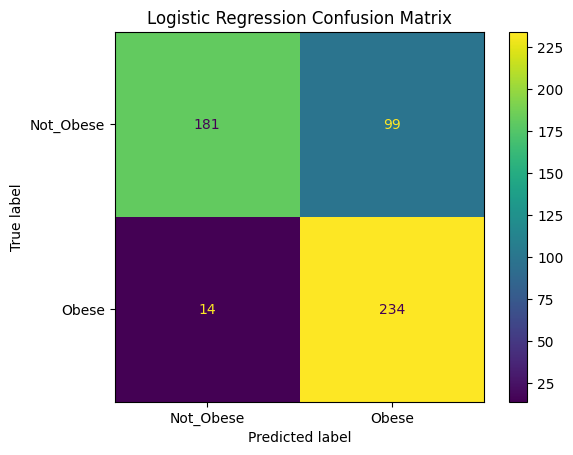

In [20]:
#from estimator
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test)
plt.title('Logistic Regression Confusion Matrix');

In [54]:
#determine feature importance
feature_names = lgr_pipe['transformer'].get_feature_names_out()
feature_importance = lgr_pipe['model'].coef_[0]
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df

,Feature,Importance
0,onehotencoder__Family_History_Overweight_yes,3.013347
1,onehotencoder__High_Caloric_Diet_yes,1.801123
2,onehotencoder__Food_Between_Meals_Frequently,-1.668490
3,onehotencoder__Food_Between_Meals_Sometimes,1.522307
4,onehotencoder__Food_Between_Meals_no,-0.553127
5,onehotencoder__Monitors_Calories_yes,-1.578759
6,remainder__Age (yrs),0.253693


# Model 2 -- KNN

In [21]:
#make pipeline
knn_pipe = Pipeline([('transformer', transformer), ('model', KNeighborsClassifier(n_neighbors = 5))])

In [22]:
knn_pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Family_History_Overweight',
                                                   'High_Caloric_Diet',
                                                   'Food_Between_Meals',
                                                   'Monitors_Calories'])])),
                ('model', KNeighborsClassifier())])

In [88]:
#scores
print(f'Train Score: {knn_pipe.score(X_train, y_train)}')
print(f'Test Score: {knn_pipe.score(X_test, y_test)}')
print()

#compare to baseline
print(f'Baseline: \n{y_train.value_counts(normalize = True)}')
print()

#recall
tn, fp, fn, tp = confusion_matrix(y_test, knn_pipe.predict(X_test)).ravel()
recall = tp / (tp + fn)
print(f'Recall: {recall}')

Train Score: 0.833859759949463
Test Score: 0.7670454545454546

Baseline: 
Weight_Level
Not_Obese    0.542641
Obese        0.457359
Name: proportion, dtype: float64

Recall: 0.7137096774193549


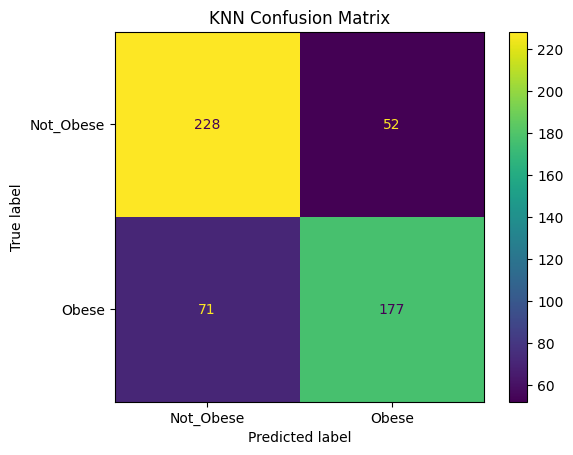

In [24]:
#confusion matrix with test data
ConfusionMatrixDisplay.from_estimator(knn_pipe, X_test, y_test)
plt.title('KNN Confusion Matrix');

In [85]:
#determine feature importance
#run permutation importance
result = permutation_importance(knn_pipe, X_test, y_test, n_repeats=10, random_state=42)

#get transformed feature names after applying the transformer
feature_names = knn_pipe.named_steps['transformer'].get_feature_names_out()

#create DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names[:len(result.importances_mean)], 'Importance': result.importances_mean}).sort_values(by='Importance', ascending=False)
importance_df

,Feature,Importance
0,onehotencoder__Family_History_Overweight_yes,0.102841
1,onehotencoder__High_Caloric_Diet_yes,0.061174
3,onehotencoder__Food_Between_Meals_Sometimes,0.057955
2,onehotencoder__Food_Between_Meals_Frequently,0.033523
4,onehotencoder__Food_Between_Meals_no,0.004167


Now, I will use GridSearchCV to find the optimal n_neighbors and use that to make another knn model:

In [25]:
#Grid Search
knn_params = {'model__n_neighbors': range(1, 30, 1)}
knn_grid = GridSearchCV(knn_pipe, param_grid = knn_params, cv = 5)

In [26]:
knn_grid.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Family_History_Overweight',
                                                                          'High_Caloric_Diet',
                                                                          'Food_Between_Meals',
                                                                          'Monitors_Calories'])])),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__n_neighbors': range(1, 30)})

In [27]:
knn_grid.best_params_

{'model__n_neighbors': 20}

In [89]:
#scores
print(f'Train Score: {knn_grid.score(X_train, y_train)}')
print(f'Test Score: {knn_grid.score(X_test, y_test)}')
print()

#compare to baseline
print(f'Baseline: \n{y_train.value_counts(normalize = True)}')
print()

#recall
tn, fp, fn, tp = confusion_matrix(y_test, knn_grid.predict(X_test)).ravel()
recall = tp / (tp + fn)
print(f'Recall: {recall}')

Train Score: 0.7997473152242578
Test Score: 0.7689393939393939

Baseline: 
Weight_Level
Not_Obese    0.542641
Obese        0.457359
Name: proportion, dtype: float64

Recall: 0.7217741935483871


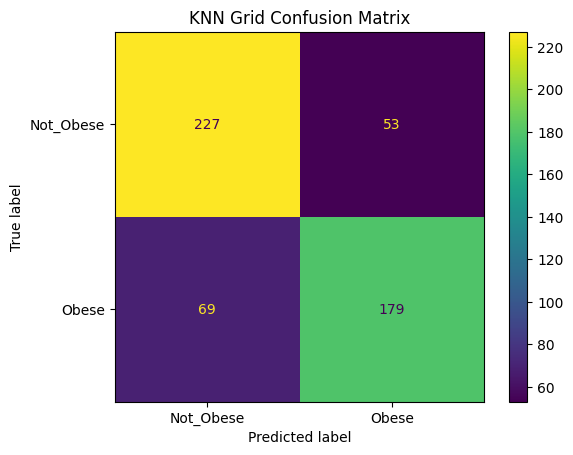

In [29]:
#confusion matrix with test data
ConfusionMatrixDisplay.from_estimator(knn_grid, X_test, y_test)
plt.title('KNN Grid Confusion Matrix');

# Model 3 -- DecisionTree

In [30]:
#make pipeline
tree_pipe = Pipeline([('transformer', transformer), ('model', DecisionTreeClassifier(criterion = 'entropy', max_depth = 4))])

In [31]:
tree_pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Family_History_Overweight',
                                                   'High_Caloric_Diet',
                                                   'Food_Between_Meals',
                                                   'Monitors_Calories'])])),
                ('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4))])

In [91]:
#score
print(f'Train Score: {tree_pipe.score(X_train, y_train)}')
print(f'Test Score: {tree_pipe.score(X_test, y_test)}')
print()

#baseline score
print(f'Baseline: \n{y_train.value_counts(normalize = True)}')
print()

#recall
tn, fp, fn, tp = confusion_matrix(y_test, tree_pipe.predict(X_test)).ravel()
recall = tp / (tp + fn)
print(f'Recall: {recall}')

Train Score: 0.7668982943777637
Test Score: 0.7897727272727273

Baseline: 
Weight_Level
Not_Obese    0.542641
Obese        0.457359
Name: proportion, dtype: float64

Recall: 0.8306451612903226


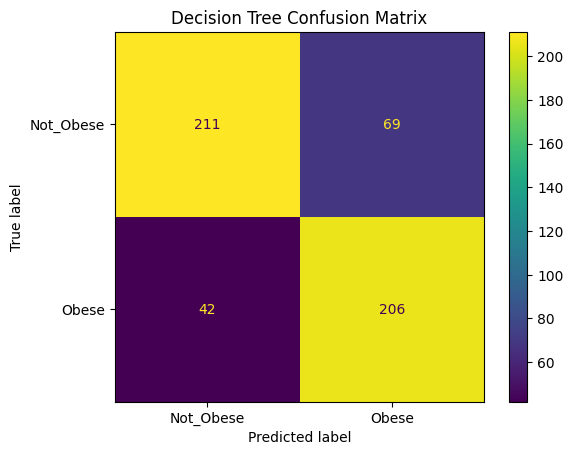

In [33]:
#ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(tree_pipe, X_test, y_test)
plt.title('Decision Tree Confusion Matrix');

In [69]:
#determine feature importance
feature_names = tree_pipe['transformer'].get_feature_names_out()
feature_importance = tree_pipe['model'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df

,Feature,Importance
0,onehotencoder__Family_History_Overweight_yes,0.507398
1,onehotencoder__High_Caloric_Diet_yes,0.068693
2,onehotencoder__Food_Between_Meals_Frequently,0.011292
3,onehotencoder__Food_Between_Meals_Sometimes,0.226093
4,onehotencoder__Food_Between_Meals_no,0.000000
5,onehotencoder__Monitors_Calories_yes,0.000000
6,remainder__Age (yrs),0.186524


Now, we will Grid Search to find the optimal max_depth for the decision tree model:

In [34]:
#Grid Search
tree_params = {'model__max_depth': range(1, 30, 1)}
tree_grid = GridSearchCV(tree_pipe, param_grid = tree_params, cv = 5)

In [35]:
tree_grid.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Family_History_Overweight',
                                                                          'High_Caloric_Diet',
                                                                          'Food_Between_Meals',
                                                                          'Monitors_Calories'])])),
                                       ('model',
                                        DecisionTreeClassifier(criterion='entropy',
                                                               max_depth=4))]),
             param_grid={'model__max_depth': range(1, 30)})

In [36]:
tree_grid.best_params_

{'model__max_depth': 8}

In [92]:
#score
print(f'Train Score: {tree_grid.score(X_train, y_train)}')
print(f'Test Score: {tree_grid.score(X_test, y_test)}')
print()

#compare with baseline
print(f'Baseline: \n{y_train.value_counts(normalize = True)}')
print()

#recall
tn, fp, fn, tp = confusion_matrix(y_test, tree_grid.predict(X_test)).ravel()
recall = tp / (tp + fn)
print(f'Recall: {recall}')

Train Score: 0.8250157927984839
Test Score: 0.7878787878787878

Baseline: 
Weight_Level
Not_Obese    0.542641
Obese        0.457359
Name: proportion, dtype: float64

Recall: 0.8104838709677419


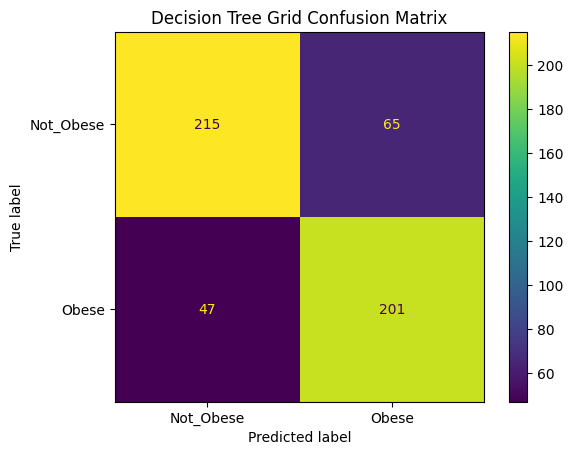

In [38]:
#ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(tree_grid, X_test, y_test)
plt.title('Decision Tree Grid Confusion Matrix');

# Model 4 -- RandomForest

In [39]:
#create pipeline
from sklearn.ensemble import RandomForestClassifier
rf_pipe = Pipeline([('transformer', transformer), ('model', RandomForestClassifier(n_estimators = 100))])

In [40]:
rf_pipe.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Family_History_Overweight',
                                                   'High_Caloric_Diet',
                                                   'Food_Between_Meals',
                                                   'Monitors_Calories'])])),
                ('model', RandomForestClassifier())])

In [93]:
#scores
print(f'Train Score: {rf_pipe.score(X_train, y_train)}')
print(f'Test Score: {rf_pipe.score(X_test, y_test)}')
print()

#compared to baseline
print(f'Baseline: \n{y_train.value_counts(normalize = True)}')
print()

#recall
tn, fp, fn, tp = confusion_matrix(y_test, rf_pipe.predict(X_test)).ravel()
recall = tp / (tp + fn)
print(f'Recall: {recall}')

Train Score: 0.9627289955780164
Test Score: 0.7840909090909091

Baseline: 
Weight_Level
Not_Obese    0.542641
Obese        0.457359
Name: proportion, dtype: float64

Recall: 0.6975806451612904


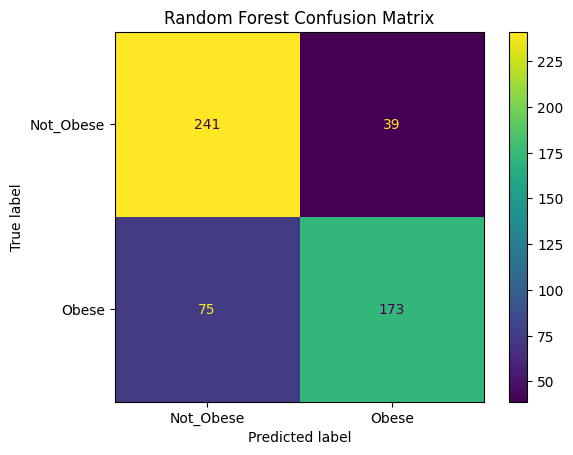

In [42]:
#ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf_pipe, X_test, y_test)
plt.title('Random Forest Confusion Matrix');

In [80]:
#determine feature importance
feature_names = rf_pipe['transformer'].get_feature_names_out()
feature_importance = rf_pipe['model'].feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df

,Feature,Importance
0,onehotencoder__Family_History_Overweight_yes,0.131085
1,onehotencoder__High_Caloric_Diet_yes,0.043941
2,onehotencoder__Food_Between_Meals_Frequently,0.038076
3,onehotencoder__Food_Between_Meals_Sometimes,0.074079
4,onehotencoder__Food_Between_Meals_no,0.003071
5,onehotencoder__Monitors_Calories_yes,0.014264
6,remainder__Age (yrs),0.695484


Now, we will Grid Search for the optimal n_estimators in the Random Forest model:

In [43]:
#grid search
rf_params = {'model__n_estimators': range(1, 100, 1)}
rf_grid = GridSearchCV(rf_pipe, param_grid = rf_params, cv = 5)

In [44]:
rf_grid.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Family_History_Overweight',
                                                                          'High_Caloric_Diet',
                                                                          'Food_Between_Meals',
                                                                          'Monitors_Calories'])])),
                                       ('model', RandomForestClassifier())]),
             param_grid={'model__n_estimators': range(1, 100)})

In [45]:
rf_grid.best_params_

{'model__n_estimators': 18}

In [94]:
#scores
print(f'Train Score: {rf_grid.score(X_train, y_train)}')
print(f'Test Score: {rf_grid.score(X_test, y_test)}')
print()

#compared to baseline
print(f'Baseline: \n{y_train.value_counts(normalize = True)}')
print()

#recall
tn, fp, fn, tp = confusion_matrix(y_test, rf_grid.predict(X_test)).ravel()
recall = tp / (tp + fn)
print(f'Recall: {recall}')

Train Score: 0.9564118761844599
Test Score: 0.7803030303030303

Baseline: 
Weight_Level
Not_Obese    0.542641
Obese        0.457359
Name: proportion, dtype: float64

Recall: 0.6854838709677419


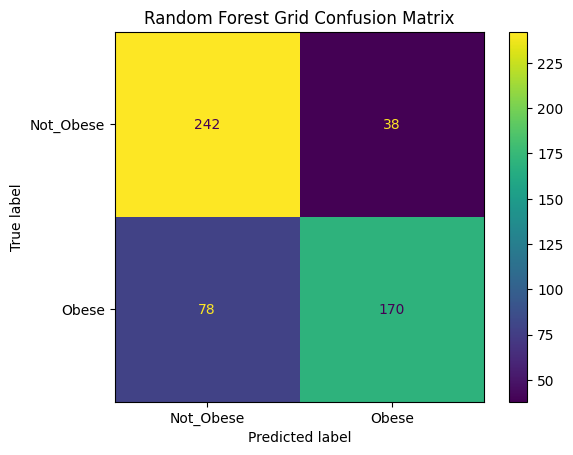

In [47]:
#ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(rf_grid, X_test, y_test)
plt.title('Random Forest Grid Confusion Matrix');